# Apr ??, 2022 ()

**Motivation**: 
<br>

In [1]:
# HIDE CODE


import os
import sys
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from numpy.ma import masked_where as mwh
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
_fig_dir = pjoin(git_dir, 'jb-Ca-fMRI/figs')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = 'Documents/workspaces/lfr/binary_overlapping'
lfr_dir = pjoin(os.environ['HOME'], lfr_dir)

# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# set style & no interpolalation
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
def quick_show(tr1, tr2, thres=0.1):
    fig, axes = create_figure(2, 5 + 1, (12, 4))
    for i in range(5 + 1):
        ax = axes[0, i]
        ax.imshow(mwh(tr1['top'] == 0, tr1['top']), cmap='Greys_r')
        ax.imshow(mwh(tr1['proj-top'][i] < thres, tr1['proj-top'][i]))
        ax = axes[1, i]
        ax.imshow(mwh(tr2['top'] == 0, tr2['top']), cmap='Greys_r')
        ax.imshow(mwh(tr2['proj-top'][i] < thres, tr2['proj-top'][i]))
    remove_ticks(axes)
    plt.show()

## Mice

In [3]:
# mice = Mice((128, 3))
mice = Mice(Config(128, 3, exclude=0))
mice.setup_func_data('rest')

mako = sns.color_palette('mako', as_cmap=True)
rocket = sns.color_palette('rocket', as_cmap=True)
pal = {'ca2': mako(0.6), 'bold-lite': rocket(0.6)}

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
gr_ca = Group(**props_ca).fit_group()
gr_bo = Group(**props_bo).fit_group()

In [47]:
def align(self, data: Union[np.ndarray, dict] = None):
    data = data if data is not None else self.load_svinets()
    accepted_runs, good_global = _good_nodes(self, data, 0.90)
    return accepted_runs, good_global

def _good_nodes(self, data: Union[np.ndarray, dict] = None, freq_q: float = 0.90):
    data = data if data is not None else self.load_svinets()
    node_presence = collections.defaultdict(list)
    ctr = 0
    if isinstance(data, np.ndarray):
        i, j, k = data.shape[:3]
        looper = itertools.product(
            range(i), range(j), range(j))
        for i, j, k in looper:
            x = data[i, j, k]
            good = np.where(np.isnan(x).sum(0) == 0)[0]
            if not len(good):
                continue
            ctr += 1
            for n in good:
                node_presence[n].append((i, j, k))
    elif isinstance(data, dict):
        for key, sv in data.items():
            if 'run' not in key:
                continue
            good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
            if not len(good):
                continue
            ctr += 1
            for n in good:
                node_presence[n].append(key)

    node_presence = dict(sorted(node_presence.items()))
    print(node_presence)
    freq = {
        n: len(v) / ctr for n, v
        in node_presence.items()
    }
    good_global = np.array([
        n for n, f in freq.items()
        if f > freq_q
    ])
    accepted_runs = []
    if isinstance(data, np.ndarray):
        i, j, k = data.shape[:3]
        looper = itertools.product(
            range(i), range(j), range(j))
        for i, j, k in looper:
            x = data[i, j, k]
            good = np.where(np.isnan(x).sum(0) == 0)[0]
            if all(e in good for e in good_global):
                accepted_runs.append((i, j, k))
    elif isinstance(data, dict):
        for key, sv in data.items():
            if 'run' not in key:
                continue
            good = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
            if all(e in good for e in good_global):
                accepted_runs.append(key)
    return accepted_runs, good_global

In [44]:
accepted_runs, good_global = align(gr_ca)
len(accepted_runs), len(good_global)

(54, 98)

In [48]:
accepted_runs, good_global = align(gr_ca, gr_ca.run_centroids)
len(accepted_runs), len(good_global)

{
    0: [(1, 0, 0), (1, 0, 1), (5, 0, 0), (5, 0, 1), (6, 0, 0)],
    1: [
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (2, 0, 0),
        (3, 1, 0),
        (3, 1, 1),
        (4, 0, 0),
        (4, 0, 1),
        (4, 1, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
        (6, 0, 0),
        (7, 0, 0),
        (7, 0, 1),
        (7, 1, 0),
        (7, 1, 1),
        (8, 0, 0),
        (8, 0, 1),
        (8, 1, 0),
        (8, 1, 1)
    ],
    2: [
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (4, 0, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
        (7, 0, 0),
        (8, 0, 0),
        (8, 1, 0),
        (8, 1, 1)
    ],
    3: [
        (1, 0, 0),
        (2, 1, 0),
        (3, 1, 0),
        (5, 0, 0),
        (5, 0, 1),
        (5, 1, 0),
        (5, 1, 1),
        (6, 0, 0),
        (7, 0, 0),
        (7, 0, 1),
        (8, 0, 0)
    ],
    4: [
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (4, 0, 0),
        (4, 0, 1),
        (5, 0, 0),
        (5, 0, 1),
        (6, 0, 0),
        (7, 0, 0),
        (7, 0, 1),
        (8, 0, 0),
        (8, 0, 1),
        (8, 1, 0),
        (8, 1, 1)
    ],
    5: [
        (0, 0, 0),
        (0, 0, 1),
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (1, 1, 0),
        (1, 1, 1),
        (2, 0, 0),
        (2, 0, 1),
        (2, 1, 0),
        (2, 1, 1),
        (3, 0, 1),
        (3, 1, 0),
        (3, 1, 1),
        (4, 0, 0),
        (4, 0, 1),
        (4, 1, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
        (5, 1, 0),
        (5, 1, 1),
        (6, 0, 0),
        (6, 0, 1),
        (6, 1, 1),
        (7, 0, 0),
        (7, 0, 1),
        (7, 1, 0),
        (7, 1, 1),
        (8, 0, 0),
        (8, 0, 1),
        (8, 1, 0),
        (8, 1, 1)
    ],
    6: [
        (0, 0, 0),
        (0, 0, 1),
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (1, 1, 0),
        (1, 1, 1),
        (2, 0, 0),
        (2, 0, 1),
        (2, 1, 0),
        (2, 1, 1),
        (3, 0, 0),
        (3, 0, 1),
        (3, 1, 0),
        (3, 1, 1),
        (4, 0, 0),
        (4, 0, 1),
        (4, 1, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
        (5, 1, 0),
        (5, 1, 1),
        (6, 0, 0),
        (6, 0, 1),
        (6, 1, 0),
        (6, 1, 1),
        (7, 0, 0),
        (7, 0, 1),
        (7, 1, 0),
        (7, 1, 1),
        (8, 0, 0),
        (8, 0, 1),
        (8, 1, 0),
        (8, 1, 1)
    ],
    7: [
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (2, 0, 0),
        (3, 0, 1),
        (4, 0, 0),
        (4, 0, 1),
        (5, 0, 0),
        (5, 0, 1),
        (5, 1, 0),
        (5, 1, 1),
        (7, 0, 0),
        (7, 0, 1),
        (7, 1, 0),
        (8, 0, 0),
        (8, 1, 0),
        (8, 1, 1)
    ],
    8: [
        (0, 0, 0),
        (0, 0, 1),
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (1, 1, 0),
        (2, 0, 0),
        (2, 1, 0),
        (2, 1, 1),
        (3, 0, 0),
        (3, 0, 1),
        (3, 1, 0),
        (3, 1, 1),
        (4, 0, 0),
        (4, 0, 1),
        (4, 1, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
        (5, 1, 0),
        (5, 1, 1),
        (6, 0, 0),
        (6, 1, 1),
        (7, 0, 0),
        (7, 0, 1),
        (7, 1, 0),
        (7, 1, 1),
        (8, 0, 0),
        (8, 0, 1),
        (8, 1, 0),
        (8, 1, 1)
    ],
    9: [
        (0, 0, 0),
        (0, 1, 0),
        (0, 1, 1),
        (1, 0, 0),
        (1, 0, 1),
        (1, 1, 0),
        (1, 1, 1),
        (2, 0, 0),
        (2, 0, 1),
        (2, 1, 0),
        (2, 1, 1),
        (3, 0, 1),
        (3, 1, 0),
        (3, 1, 1),
        (4, 0, 0),
        (4, 0, 1),
        (4, 1, 0),
        (4, 1, 1),
        (5, 0, 0),
        (5, 0, 1),
     

(18, 98)

In [ ]:
np.isnan(x).sum(0)

In [56]:
data = gr_ca.run_centroids
i, j, k = data.shape[:3]
looper = itertools.product(
    range(i), range(j), range(j))

ctr = 0
for i, j, k in looper:
    x = data[i, j, k]
    good = np.where(np.isnan(x).sum(0) == 0)[0]
    print(i, j, k, collections.Counter(np.isnan(x).sum(0)), len(good))
    
    if not len(good):
        continue

    ctr += 1

0 0 0
Counter({5: 15, 0: 139})
139

0 0 1
Counter({5: 20, 0: 134})
134

0 0 2
Counter({5: 154})
0

0 1 0
Counter({5: 13, 0: 141})
141

0 1 1
Counter({5: 20, 0: 134})
134

0 1 2
Counter({5: 154})
0

0 2 0
Counter({5: 154})
0

0 2 1
Counter({5: 154})
0

0 2 2
Counter({5: 154})
0

1 0 0
Counter({0: 138, 5: 16})
138

1 0 1
Counter({0: 139, 5: 15})
139

1 0 2
Counter({5: 154})
0

1 1 0
Counter({5: 22, 0: 132})
132

1 1 1
Counter({5: 25, 0: 129})
129

1 1 2
Counter({5: 154})
0

1 2 0
Counter({5: 154})
0

1 2 1
Counter({5: 154})
0

1 2 2
Counter({5: 154})
0

2 0 0
Counter({5: 19, 0: 135})
135

2 0 1
Counter({5: 39, 0: 115})
115

2 0 2
Counter({5: 154})
0

2 1 0
Counter({5: 26, 0: 128})
128

2 1 1
Counter({5: 30, 0: 124})
124

2 1 2
Counter({5: 154})
0

2 2 0
Counter({5: 154})
0

2 2 1
Counter({5: 154})
0

2 2 2
Counter({5: 154})
0

3 0 0
Counter({5: 28, 0: 126})
126

3 0 1
Counter({5: 17, 0: 137})
137

3 0 2
Counter({5: 154})
0

3 1 0
Counter({5: 32, 0: 122})
122

3 1 1
Counter({5: 32, 0: 122})
122

3 1 2
Counter({5: 154})
0

3 2 0
Counter({5: 154})
0

3 2 1
Counter({5: 154})
0

3 2 2
Counter({5: 154})
0

4 0 0
Counter({5: 22, 0: 132})
132

4 0 1
Counter({5: 30, 0: 124})
124

4 0 2
Counter({5: 154})
0

4 1 0
Counter({5: 16, 0: 138})
138

4 1 1
Counter({5: 53, 0: 101})
101

4 1 2
Counter({5: 154})
0

4 2 0
Counter({5: 154})
0

4 2 1
Counter({5: 154})
0

4 2 2
Counter({5: 154})
0

5 0 0
Counter({0: 143, 5: 11})
143

5 0 1
Counter({0: 147, 5: 7})
147

5 0 2
Counter({5: 154})
0

5 1 0
Counter({5: 12, 0: 142})
142

5 1 1
Counter({5: 14, 0: 140})
140

5 1 2
Counter({5: 154})
0

5 2 0
Counter({5: 154})
0

5 2 1
Counter({5: 154})
0

5 2 2
Counter({5: 154})
0

6 0 0
Counter({0: 140, 5: 14})
140

6 0 1
Counter({5: 26, 0: 128})
128

6 0 2
Counter({5: 154})
0

6 1 0
Counter({5: 22, 0: 132})
132

6 1 1
Counter({5: 16, 0: 138})
138

6 1 2
Counter({5: 154})
0

6 2 0
Counter({5: 154})
0

6 2 1
Counter({5: 154})
0

6 2 2
Counter({5: 154})
0

7 0 0
Counter({5: 7, 0: 147})
147

7 0 1
Counter({5: 8, 0: 146})
146

7 0 2
Counter({5: 154})
0

7 1 0
Counter({5: 16, 0: 138})
138

7 1 1
Counter({5: 19, 0: 135})
135

7 1 2
Counter({5: 154})
0

7 2 0
Counter({5: 154})
0

7 2 1
Counter({5: 154})
0

7 2 2
Counter({5: 154})
0

8 0 0
Counter({5: 31, 0: 123})
123

8 0 1
Counter({5: 24, 0: 130})
130

8 0 2
Counter({5: 154})
0

8 1 0
Counter({5: 20, 0: 134})
134

8 1 1
Counter({5: 20, 0: 134})
134

8 1 2
Counter({5: 154})
0

8 2 0
Counter({5: 154})
0

8 2 1
Counter({5: 154})
0

8 2 2
Counter({5: 154})
0

9 0 0
Counter({5: 154})
0

9 0 1
Counter({5: 154})
0

9 0 2
Counter({5: 154})
0

9 1 0
Counter({5: 154})
0

9 1 1
Counter({5: 154})
0

9 1 2
Counter({5: 154})
0

9 2 0
Counter({5: 154})
0

9 2 1
Counter({5: 154})
0

9 2 2
Counter({5: 154})
0

In [57]:
ctr

36

In [58]:
x = gr_ca.run_centroids[4, 1, 1]
x.shape

(5, 154)

In [59]:
tr = gr_ca.project_vec(x)
tr = gr_ca.trim2d(tr)

<matplotlib.image.AxesImage object at 0x7fd7908d00d0>

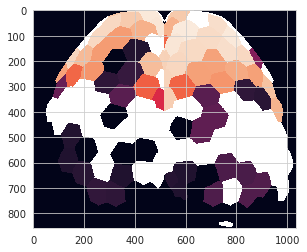

In [68]:
plt.imshow(tr['proj-top'][2])

In [69]:
svinets = gr_ca.load_svinets()

In [71]:
key = mice.get_key(5, 2, 3)
sv = svinets[key]

In [73]:
tr2 = gr_ca.project_vec(sv.pi)
tr2 = gr_ca.trim2d(tr2)

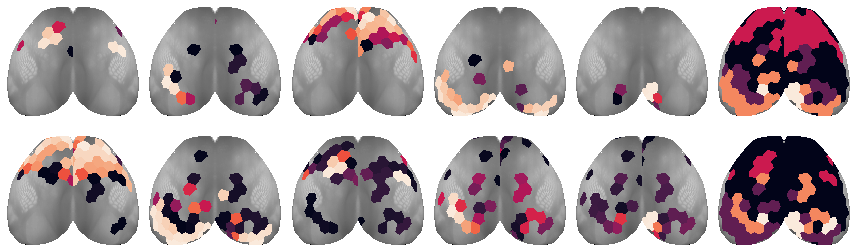

In [74]:
quick_show(tr, tr2)

In [49]:

key = 'sub-SLC08_ses-1_run-5'
mode = 'bold-lite'
gr = Group(mice, num_k, mode=mode)
sv = SVINET(mice, num_k, perc, key, mode)
self = sv

current expt: 'p10-sample'

In [50]:
_ = sv.load_runs()

[PROGRESS] experiment loaded: 'k = 5, p10-sample',  total # runs:  488

[PROGRESS] some runs were excluded:     12 x k = 4

In [56]:
run_name = 'n101-k5-mmsb-seed49-linksampling'
run = sv._runs['p10-sample'][run_name]
list(run)

[
    'valid',
    'gamma_sv',
    'lambda_sv',
    'community_sv',
    'membership_sv',
    'partition_sv',
    'num_missing',
    'num_overlap',
    'gam',
    'lam',
    'pi'
]

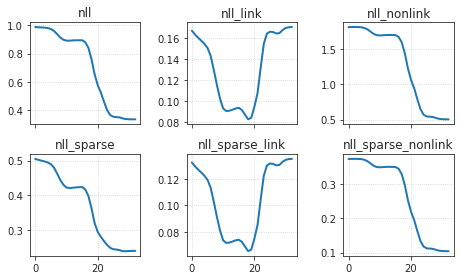

In [57]:
fig, axes = create_figure(2, 3, (6.5, 4), 'all')
data2p = {k: v for k, v in run['valid'].items() if 'nll' in k}
for ax, (k, x) in zip(axes.ravel(), data2p.items()):
    ax.plot(x, lw=2)
    ax.set_title(k)
    ax.grid()

In [58]:
x = run['gam'].copy()
x /= x.sum(-2, keepdims=True)

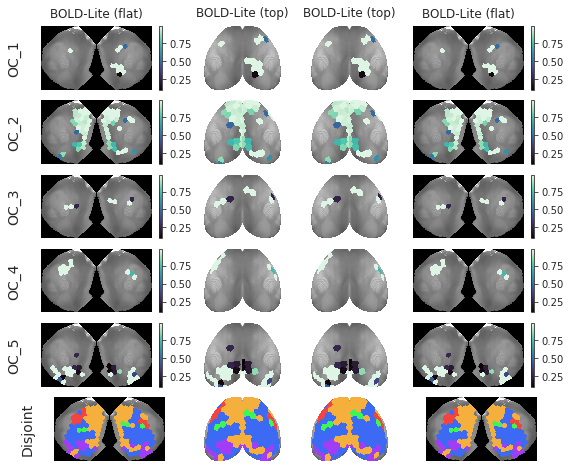

In [59]:
tr1 = gr.project_vec(x)
tr2 = gr.project_vec(run['pi'])
_ = gr.show(tr1, tr2, cmaps=('mako',) * 2, fix_cmap=False)

<matplotlib.image.AxesImage object at 0x7f3b4647f5b0>

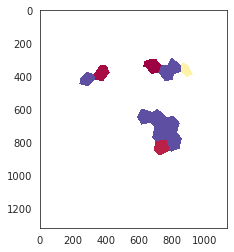

In [60]:
plt.imshow(mwh(tr1['top'][0] < 0.05, tr1['top'][0]), cmap='Spectral')

In [61]:
data = sv._cat_data(raw=True, which=sv.match_using)
sv.match_using, data.shape

('gam', (2440, 154))

In [62]:
centroids, _ = fit_kmeans(
    data=data,
    n_clusters=sv.num_k,
    match_metric=sv.match_metric,
    random_state=sv.mice.cfg.random_state,
    normalize=sv.normalize,
    verbose=True,
)
centroids.shape

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


[PROGRESS] kmeans fit: done

(5, 154)

In [63]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric='correlation',
    cortex_only=True,
    global_order=False,
    assert_equal=False,
)

In [64]:
self.centroids = centroids[global_mapping]

In [65]:
x = centroids.copy()
x /= x.sum(-2, keepdims=True)
tr1 = gr.project_vec(x)
tr1 = gr.trim2d(tr1)

x = self.centroids.copy()
x /= x.sum(-2, keepdims=True)
tr2 = gr.project_vec(x)
tr2 = gr.trim2d(tr2)

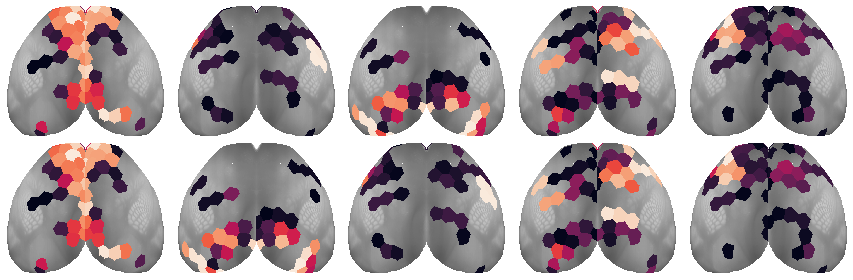

In [66]:
quick_show(tr1, tr2)

In [67]:
self.perms = self._perms(data, 'correlation')

[PROGRESS] find best mappings: done

In [68]:
self._align()

warning type 1 at n101-k5-mmsb-seed1-linksampling

warning type 1 at n101-k5-mmsb-seed2-linksampling

warning type 1 at n101-k5-mmsb-seed3-linksampling

warning type 1 at n101-k5-mmsb-seed5-linksampling

warning type 1 at n101-k5-mmsb-seed6-linksampling

warning type 1 at n101-k5-mmsb-seed7-linksampling

warning type 1 at n101-k5-mmsb-seed8-linksampling

warning type 1 at n101-k5-mmsb-seed9-linksampling

warning type 1 at n101-k5-mmsb-seed10-linksampling

warning type 1 at n101-k5-mmsb-seed11-linksampling

warning type 1 at n101-k5-mmsb-seed12-linksampling

warning type 1 at n101-k5-mmsb-seed13-linksampling

warning type 1 at n101-k5-mmsb-seed14-linksampling

warning type 1 at n101-k5-mmsb-seed15-linksampling

warning type 1 at n101-k5-mmsb-seed16-linksampling

warning type 1 at n101-k5-mmsb-seed17-linksampling

warning type 1 at n101-k5-mmsb-seed18-linksampling

warning type 1 at n101-k5-mmsb-seed19-linksampling

warning type 1 at n101-k5-mmsb-seed20-linksampling

warning type 1 at n101-k5-mmsb-seed21-linksampling

warning type 1 at n101-k5-mmsb-seed22-linksampling

warning type 1 at n101-k5-mmsb-seed24-linksampling

warning type 1 at n101-k5-mmsb-seed25-linksampling

warning type 1 at n101-k5-mmsb-seed26-linksampling

warning type 1 at n101-k5-mmsb-seed27-linksampling

warning type 1 at n101-k5-mmsb-seed28-linksampling

warning type 1 at n101-k5-mmsb-seed29-linksampling

warning type 1 at n101-k5-mmsb-seed31-linksampling

warning type 1 at n101-k5-mmsb-seed32-linksampling

warning type 1 at n101-k5-mmsb-seed33-linksampling

warning type 1 at n101-k5-mmsb-seed34-linksampling

warning type 1 at n101-k5-mmsb-seed36-linksampling

warning type 1 at n101-k5-mmsb-seed37-linksampling

warning type 1 at n101-k5-mmsb-seed38-linksampling

warning type 1 at n101-k5-mmsb-seed41-linksampling

warning type 1 at n101-k5-mmsb-seed42-linksampling

warning type 1 at n101-k5-mmsb-seed43-linksampling

warning type 1 at n101-k5-mmsb-seed44-linksampling

warning type 1 at n101-k5-mmsb-seed45-linksampling

warning type 1 at n101-k5-mmsb-seed46-linksampling

warning type 1 at n101-k5-mmsb-seed48-linksampling

warning type 1 at n101-k5-mmsb-seed49-linksampling

warning type 1 at n101-k5-mmsb-seed50-linksampling

warning type 1 at n101-k5-mmsb-seed51-linksampling

warning type 1 at n101-k5-mmsb-seed53-linksampling

warning type 1 at n101-k5-mmsb-seed54-linksampling

warning type 1 at n101-k5-mmsb-seed55-linksampling

warning type 1 at n101-k5-mmsb-seed56-linksampling

warning type 1 at n101-k5-mmsb-seed57-linksampling

warning type 1 at n101-k5-mmsb-seed58-linksampling

warning type 1 at n101-k5-mmsb-seed60-linksampling

warning type 1 at n101-k5-mmsb-seed61-linksampling

warning type 1 at n101-k5-mmsb-seed62-linksampling

warning type 1 at n101-k5-mmsb-seed63-linksampling

warning type 1 at n101-k5-mmsb-seed64-linksampling

warning type 1 at n101-k5-mmsb-seed65-linksampling

warning type 1 at n101-k5-mmsb-seed66-linksampling

warning type 1 at n101-k5-mmsb-seed68-linksampling

warning type 1 at n101-k5-mmsb-seed69-linksampling

warning type 1 at n101-k5-mmsb-seed70-linksampling

warning type 1 at n101-k5-mmsb-seed71-linksampling

warning type 1 at n101-k5-mmsb-seed72-linksampling

warning type 1 at n101-k5-mmsb-seed73-linksampling

warning type 1 at n101-k5-mmsb-seed74-linksampling

warning type 1 at n101-k5-mmsb-seed75-linksampling

warning type 1 at n101-k5-mmsb-seed77-linksampling

warning type 1 at n101-k5-mmsb-seed78-linksampling

warning type 1 at n101-k5-mmsb-seed79-linksampling

warning type 1 at n101-k5-mmsb-seed80-linksampling

warning type 1 at n101-k5-mmsb-seed81-linksampling

warning type 1 at n101-k5-mmsb-seed82-linksampling

warning type 1 at n101-k5-mmsb-seed83-linksampling

warning type 1 at n101-k5-mmsb-seed84-linksampling

warning type 1 at n101-k5-mmsb-seed85-linksampling

warning type 1 at n101-k5-mmsb-seed86-linksampling

warning type 1 at n101-k5-mmsb-seed87-linksampling

warning type 1 at n101-k5-mmsb-seed89-linksampling

warning type 1 at n101-k5-mmsb-seed90-linksampling

warning type 1 at n101-k5-mmsb-seed91-linksampling

warning type 1 at n101-k5-mmsb-seed92-linksampling

warning type 1 at n101-k5-mmsb-seed95-linksampling

warning type 1 at n101-k5-mmsb-seed96-linksampling

warning type 1 at n101-k5-mmsb-seed97-linksampling

warning type 1 at n101-k5-mmsb-seed99-linksampling

warning type 1 at n101-k5-mmsb-seed100-linksampling

warning type 1 at n101-k5-mmsb-seed101-linksampling

warning type 1 at n101-k5-mmsb-seed102-linksampling

warning type 1 at n101-k5-mmsb-seed103-linksampling

warning type 1 at n101-k5-mmsb-seed105-linksampling

warning type 1 at n101-k5-mmsb-seed106-linksampling

warning type 1 at n101-k5-mmsb-seed107-linksampling

warning type 1 at n101-k5-mmsb-seed108-linksampling

warning type 1 at n101-k5-mmsb-seed109-linksampling

warning type 1 at n101-k5-mmsb-seed111-linksampling

warning type 1 at n101-k5-mmsb-seed112-linksampling

warning type 1 at n101-k5-mmsb-seed113-linksampling

warning type 1 at n101-k5-mmsb-seed114-linksampling

warning type 1 at n101-k5-mmsb-seed115-linksampling

warning type 1 at n101-k5-mmsb-seed116-linksampling

warning type 1 at n101-k5-mmsb-seed117-linksampling

warning type 1 at n101-k5-mmsb-seed118-linksampling

warning type 1 at n101-k5-mmsb-seed119-linksampling

warning type 1 at n101-k5-mmsb-seed121-linksampling

warning type 1 at n101-k5-mmsb-seed122-linksampling

warning type 1 at n101-k5-mmsb-seed123-linksampling

warning type 1 at n101-k5-mmsb-seed124-linksampling

warning type 1 at n101-k5-mmsb-seed126-linksampling

warning type 1 at n101-k5-mmsb-seed128-linksampling

warning type 1 at n101-k5-mmsb-seed129-linksampling

warning type 1 at n101-k5-mmsb-seed131-linksampling

warning type 1 at n101-k5-mmsb-seed133-linksampling

warning type 1 at n101-k5-mmsb-seed134-linksampling

warning type 1 at n101-k5-mmsb-seed135-linksampling

warning type 1 at n101-k5-mmsb-seed136-linksampling

warning type 1 at n101-k5-mmsb-seed137-linksampling

warning type 1 at n101-k5-mmsb-seed138-linksampling

warning type 1 at n101-k5-mmsb-seed140-linksampling

warning type 1 at n101-k5-mmsb-seed141-linksampling

warning type 1 at n101-k5-mmsb-seed142-linksampling

warning type 1 at n101-k5-mmsb-seed143-linksampling

warning type 1 at n101-k5-mmsb-seed144-linksampling

warning type 1 at n101-k5-mmsb-seed145-linksampling

warning type 1 at n101-k5-mmsb-seed146-linksampling

warning type 1 at n101-k5-mmsb-seed147-linksampling

warning type 1 at n101-k5-mmsb-seed148-linksampling

warning type 1 at n101-k5-mmsb-seed149-linksampling

warning type 1 at n101-k5-mmsb-seed150-linksampling

warning type 1 at n101-k5-mmsb-seed152-linksampling

warning type 1 at n101-k5-mmsb-seed153-linksampling

warning type 1 at n101-k5-mmsb-seed154-linksampling

warning type 1 at n101-k5-mmsb-seed155-linksampling

warning type 1 at n101-k5-mmsb-seed156-linksampling

warning type 1 at n101-k5-mmsb-seed157-linksampling

warning type 1 at n101-k5-mmsb-seed158-linksampling

warning type 1 at n101-k5-mmsb-seed159-linksampling

warning type 1 at n101-k5-mmsb-seed160-linksampling

warning type 1 at n101-k5-mmsb-seed161-linksampling

warning type 1 at n101-k5-mmsb-seed162-linksampling

warning type 1 at n101-k5-mmsb-seed163-linksampling

warning type 1 at n101-k5-mmsb-seed164-linksampling

warning type 1 at n101-k5-mmsb-seed165-linksampling

warning type 1 at n101-k5-mmsb-seed166-linksampling

warning type 1 at n101-k5-mmsb-seed167-linksampling

warning type 1 at n101-k5-mmsb-seed169-linksampling

warning type 1 at n101-k5-mmsb-seed170-linksampling

warning type 1 at n101-k5-mmsb-seed171-linksampling

warning type 1 at n101-k5-mmsb-seed172-linksampling

warning type 1 at n101-k5-mmsb-seed174-linksampling

warning type 1 at n101-k5-mmsb-seed175-linksampling

warning type 1 at n101-k5-mmsb-seed177-linksampling

warning type 1 at n101-k5-mmsb-seed178-linksampling

warning type 1 at n101-k5-mmsb-seed179-linksampling

warning type 1 at n101-k5-mmsb-seed180-linksampling

warning type 1 at n101-k5-mmsb-seed181-linksampling

warning type 1 at n101-k5-mmsb-seed183-linksampling

warning type 1 at n101-k5-mmsb-seed184-linksampling

warning type 1 at n101-k5-mmsb-seed185-linksampling

warning type 1 at n101-k5-mmsb-seed186-linksampling

warning type 1 at n101-k5-mmsb-seed187-linksampling

warning type 1 at n101-k5-mmsb-seed188-linksampling

warning type 1 at n101-k5-mmsb-seed192-linksampling

warning type 1 at n101-k5-mmsb-seed195-linksampling

warning type 1 at n101-k5-mmsb-seed196-linksampling

warning type 1 at n101-k5-mmsb-seed197-linksampling

warning type 1 at n101-k5-mmsb-seed199-linksampling

warning type 1 at n101-k5-mmsb-seed200-linksampling

warning type 1 at n101-k5-mmsb-seed201-linksampling

warning type 1 at n101-k5-mmsb-seed202-linksampling

warning type 1 at n101-k5-mmsb-seed204-linksampling

warning type 1 at n101-k5-mmsb-seed205-linksampling

warning type 1 at n101-k5-mmsb-seed206-linksampling

warning type 1 at n101-k5-mmsb-seed208-linksampling

warning type 1 at n101-k5-mmsb-seed209-linksampling

warning type 1 at n101-k5-mmsb-seed210-linksampling

warning type 1 at n101-k5-mmsb-seed211-linksampling

warning type 1 at n101-k5-mmsb-seed213-linksampling

warning type 1 at n101-k5-mmsb-seed214-linksampling

warning type 1 at n101-k5-mmsb-seed215-linksampling

warning type 1 at n101-k5-mmsb-seed216-linksampling

warning type 1 at n101-k5-mmsb-seed217-linksampling

warning type 1 at n101-k5-mmsb-seed218-linksampling

warning type 1 at n101-k5-mmsb-seed220-linksampling

warning type 1 at n101-k5-mmsb-seed222-linksampling

warning type 1 at n101-k5-mmsb-seed223-linksampling

warning type 1 at n101-k5-mmsb-seed225-linksampling

warning type 1 at n101-k5-mmsb-seed226-linksampling

warning type 1 at n101-k5-mmsb-seed228-linksampling

warning type 1 at n101-k5-mmsb-seed229-linksampling

warning type 1 at n101-k5-mmsb-seed230-linksampling

warning type 1 at n101-k5-mmsb-seed231-linksampling

warning type 1 at n101-k5-mmsb-seed232-linksampling

warning type 1 at n101-k5-mmsb-seed233-linksampling

warning type 1 at n101-k5-mmsb-seed234-linksampling

warning type 1 at n101-k5-mmsb-seed235-linksampling

warning type 1 at n101-k5-mmsb-seed236-linksampling

warning type 1 at n101-k5-mmsb-seed237-linksampling

warning type 1 at n101-k5-mmsb-seed238-linksampling

warning type 1 at n101-k5-mmsb-seed240-linksampling

warning type 1 at n101-k5-mmsb-seed243-linksampling

warning type 1 at n101-k5-mmsb-seed244-linksampling

warning type 1 at n101-k5-mmsb-seed245-linksampling

warning type 1 at n101-k5-mmsb-seed246-linksampling

warning type 1 at n101-k5-mmsb-seed247-linksampling

warning type 1 at n101-k5-mmsb-seed248-linksampling

warning type 1 at n101-k5-mmsb-seed249-linksampling

warning type 1 at n101-k5-mmsb-seed250-linksampling

warning type 1 at n101-k5-mmsb-seed251-linksampling

warning type 1 at n101-k5-mmsb-seed253-linksampling

warning type 1 at n101-k5-mmsb-seed255-linksampling

warning type 1 at n101-k5-mmsb-seed256-linksampling

warning type 1 at n101-k5-mmsb-seed257-linksampling

warning type 1 at n101-k5-mmsb-seed260-linksampling

warning type 1 at n101-k5-mmsb-seed261-linksampling

warning type 1 at n101-k5-mmsb-seed262-linksampling

warning type 1 at n101-k5-mmsb-seed264-linksampling

warning type 1 at n101-k5-mmsb-seed266-linksampling

warning type 1 at n101-k5-mmsb-seed267-linksampling

warning type 1 at n101-k5-mmsb-seed269-linksampling

warning type 1 at n101-k5-mmsb-seed270-linksampling

warning type 1 at n101-k5-mmsb-seed271-linksampling

warning type 1 at n101-k5-mmsb-seed272-linksampling

warning type 1 at n101-k5-mmsb-seed273-linksampling

warning type 1 at n101-k5-mmsb-seed275-linksampling

warning type 1 at n101-k5-mmsb-seed277-linksampling

warning type 1 at n101-k5-mmsb-seed279-linksampling

warning type 1 at n101-k5-mmsb-seed280-linksampling

warning type 1 at n101-k5-mmsb-seed281-linksampling

warning type 1 at n101-k5-mmsb-seed282-linksampling

warning type 1 at n101-k5-mmsb-seed283-linksampling

warning type 1 at n101-k5-mmsb-seed284-linksampling

warning type 1 at n101-k5-mmsb-seed285-linksampling

warning type 1 at n101-k5-mmsb-seed286-linksampling

warning type 1 at n101-k5-mmsb-seed287-linksampling

warning type 1 at n101-k5-mmsb-seed288-linksampling

warning type 1 at n101-k5-mmsb-seed290-linksampling

warning type 1 at n101-k5-mmsb-seed291-linksampling

warning type 1 at n101-k5-mmsb-seed292-linksampling

warning type 1 at n101-k5-mmsb-seed293-linksampling

warning type 1 at n101-k5-mmsb-seed294-linksampling

warning type 1 at n101-k5-mmsb-seed295-linksampling

warning type 1 at n101-k5-mmsb-seed296-linksampling

warning type 1 at n101-k5-mmsb-seed297-linksampling

warning type 1 at n101-k5-mmsb-seed298-linksampling

warning type 1 at n101-k5-mmsb-seed299-linksampling

warning type 1 at n101-k5-mmsb-seed300-linksampling

warning type 1 at n101-k5-mmsb-seed301-linksampling

warning type 1 at n101-k5-mmsb-seed302-linksampling

warning type 1 at n101-k5-mmsb-seed303-linksampling

warning type 1 at n101-k5-mmsb-seed304-linksampling

warning type 1 at n101-k5-mmsb-seed305-linksampling

warning type 1 at n101-k5-mmsb-seed307-linksampling

warning type 1 at n101-k5-mmsb-seed308-linksampling

warning type 1 at n101-k5-mmsb-seed309-linksampling

warning type 1 at n101-k5-mmsb-seed310-linksampling

warning type 1 at n101-k5-mmsb-seed311-linksampling

warning type 1 at n101-k5-mmsb-seed313-linksampling

warning type 1 at n101-k5-mmsb-seed316-linksampling

warning type 1 at n101-k5-mmsb-seed317-linksampling

warning type 1 at n101-k5-mmsb-seed318-linksampling

warning type 1 at n101-k5-mmsb-seed319-linksampling

warning type 1 at n101-k5-mmsb-seed320-linksampling

warning type 1 at n101-k5-mmsb-seed321-linksampling

warning type 1 at n101-k5-mmsb-seed322-linksampling

warning type 1 at n101-k5-mmsb-seed323-linksampling

warning type 1 at n101-k5-mmsb-seed324-linksampling

warning type 1 at n101-k5-mmsb-seed325-linksampling

warning type 1 at n101-k5-mmsb-seed326-linksampling

warning type 1 at n101-k5-mmsb-seed327-linksampling

warning type 1 at n101-k5-mmsb-seed328-linksampling

warning type 1 at n101-k5-mmsb-seed329-linksampling

warning type 1 at n101-k5-mmsb-seed330-linksampling

warning type 1 at n101-k5-mmsb-seed331-linksampling

warning type 1 at n101-k5-mmsb-seed332-linksampling

warning type 1 at n101-k5-mmsb-seed336-linksampling

warning type 1 at n101-k5-mmsb-seed337-linksampling

warning type 1 at n101-k5-mmsb-seed338-linksampling

warning type 1 at n101-k5-mmsb-seed340-linksampling

warning type 1 at n101-k5-mmsb-seed344-linksampling

warning type 1 at n101-k5-mmsb-seed347-linksampling

warning type 1 at n101-k5-mmsb-seed348-linksampling

warning type 1 at n101-k5-mmsb-seed349-linksampling

warning type 1 at n101-k5-mmsb-seed351-linksampling

warning type 1 at n101-k5-mmsb-seed352-linksampling

warning type 1 at n101-k5-mmsb-seed353-linksampling

warning type 1 at n101-k5-mmsb-seed357-linksampling

warning type 1 at n101-k5-mmsb-seed358-linksampling

warning type 1 at n101-k5-mmsb-seed360-linksampling

warning type 1 at n101-k5-mmsb-seed362-linksampling

warning type 1 at n101-k5-mmsb-seed363-linksampling

warning type 1 at n101-k5-mmsb-seed364-linksampling

warning type 1 at n101-k5-mmsb-seed365-linksampling

warning type 1 at n101-k5-mmsb-seed366-linksampling

warning type 1 at n101-k5-mmsb-seed367-linksampling

warning type 1 at n101-k5-mmsb-seed368-linksampling

warning type 1 at n101-k5-mmsb-seed369-linksampling

warning type 1 at n101-k5-mmsb-seed370-linksampling

warning type 1 at n101-k5-mmsb-seed372-linksampling

warning type 1 at n101-k5-mmsb-seed373-linksampling

warning type 1 at n101-k5-mmsb-seed375-linksampling

warning type 1 at n101-k5-mmsb-seed377-linksampling

warning type 1 at n101-k5-mmsb-seed378-linksampling

warning type 1 at n101-k5-mmsb-seed380-linksampling

warning type 1 at n101-k5-mmsb-seed382-linksampling

warning type 1 at n101-k5-mmsb-seed383-linksampling

warning type 1 at n101-k5-mmsb-seed384-linksampling

warning type 1 at n101-k5-mmsb-seed387-linksampling

warning type 1 at n101-k5-mmsb-seed388-linksampling

warning type 1 at n101-k5-mmsb-seed389-linksampling

warning type 1 at n101-k5-mmsb-seed390-linksampling

warning type 1 at n101-k5-mmsb-seed391-linksampling

warning type 1 at n101-k5-mmsb-seed392-linksampling

warning type 1 at n101-k5-mmsb-seed393-linksampling

warning type 1 at n101-k5-mmsb-seed395-linksampling

warning type 1 at n101-k5-mmsb-seed396-linksampling

warning type 1 at n101-k5-mmsb-seed397-linksampling

warning type 1 at n101-k5-mmsb-seed398-linksampling

warning type 1 at n101-k5-mmsb-seed399-linksampling

warning type 1 at n101-k5-mmsb-seed401-linksampling

warning type 1 at n101-k5-mmsb-seed402-linksampling

warning type 1 at n101-k5-mmsb-seed403-linksampling

warning type 1 at n101-k5-mmsb-seed405-linksampling

warning type 1 at n101-k5-mmsb-seed406-linksampling

warning type 1 at n101-k5-mmsb-seed408-linksampling

warning type 1 at n101-k5-mmsb-seed411-linksampling

warning type 1 at n101-k5-mmsb-seed412-linksampling

warning type 1 at n101-k5-mmsb-seed413-linksampling

warning type 1 at n101-k5-mmsb-seed414-linksampling

warning type 1 at n101-k5-mmsb-seed415-linksampling

warning type 1 at n101-k5-mmsb-seed416-linksampling

warning type 1 at n101-k5-mmsb-seed418-linksampling

warning type 1 at n101-k5-mmsb-seed419-linksampling

warning type 1 at n101-k5-mmsb-seed421-linksampling

warning type 1 at n101-k5-mmsb-seed422-linksampling

warning type 1 at n101-k5-mmsb-seed425-linksampling

warning type 1 at n101-k5-mmsb-seed426-linksampling

warning type 1 at n101-k5-mmsb-seed429-linksampling

warning type 1 at n101-k5-mmsb-seed430-linksampling

warning type 1 at n101-k5-mmsb-seed431-linksampling

warning type 1 at n101-k5-mmsb-seed433-linksampling

warning type 1 at n101-k5-mmsb-seed434-linksampling

warning type 1 at n101-k5-mmsb-seed436-linksampling

warning type 1 at n101-k5-mmsb-seed437-linksampling

warning type 1 at n101-k5-mmsb-seed440-linksampling

warning type 1 at n101-k5-mmsb-seed442-linksampling

warning type 1 at n101-k5-mmsb-seed443-linksampling

warning type 1 at n101-k5-mmsb-seed444-linksampling

warning type 1 at n101-k5-mmsb-seed445-linksampling

warning type 1 at n101-k5-mmsb-seed447-linksampling

warning type 1 at n101-k5-mmsb-seed448-linksampling

warning type 1 at n101-k5-mmsb-seed450-linksampling

warning type 1 at n101-k5-mmsb-seed451-linksampling

warning type 1 at n101-k5-mmsb-seed452-linksampling

warning type 1 at n101-k5-mmsb-seed453-linksampling

warning type 1 at n101-k5-mmsb-seed454-linksampling

warning type 1 at n101-k5-mmsb-seed455-linksampling

warning type 1 at n101-k5-mmsb-seed457-linksampling

warning type 1 at n101-k5-mmsb-seed459-linksampling

warning type 1 at n101-k5-mmsb-seed460-linksampling

warning type 1 at n101-k5-mmsb-seed461-linksampling

warning type 1 at n101-k5-mmsb-seed462-linksampling

warning type 1 at n101-k5-mmsb-seed464-linksampling

warning type 1 at n101-k5-mmsb-seed466-linksampling

warning type 1 at n101-k5-mmsb-seed467-linksampling

warning type 1 at n101-k5-mmsb-seed470-linksampling

warning type 1 at n101-k5-mmsb-seed471-linksampling

warning type 1 at n101-k5-mmsb-seed472-linksampling

warning type 1 at n101-k5-mmsb-seed473-linksampling

warning type 1 at n101-k5-mmsb-seed474-linksampling

warning type 1 at n101-k5-mmsb-seed475-linksampling

warning type 1 at n101-k5-mmsb-seed480-linksampling

warning type 1 at n101-k5-mmsb-seed481-linksampling

warning type 1 at n101-k5-mmsb-seed482-linksampling

warning type 1 at n101-k5-mmsb-seed483-linksampling

warning type 1 at n101-k5-mmsb-seed484-linksampling

warning type 1 at n101-k5-mmsb-seed485-linksampling

warning type 1 at n101-k5-mmsb-seed486-linksampling

warning type 1 at n101-k5-mmsb-seed488-linksampling

warning type 1 at n101-k5-mmsb-seed489-linksampling

warning type 1 at n101-k5-mmsb-seed490-linksampling

warning type 1 at n101-k5-mmsb-seed492-linksampling

warning type 1 at n101-k5-mmsb-seed493-linksampling

warning type 1 at n101-k5-mmsb-seed494-linksampling

warning type 1 at n101-k5-mmsb-seed496-linksampling

warning type 1 at n101-k5-mmsb-seed497-linksampling

warning type 1 at n101-k5-mmsb-seed498-linksampling

warning type 1 at n101-k5-mmsb-seed500-linksampling

[PROGRESS] results aligned: done

In [69]:
gam_all = self._cat_data(raw=False, which='gam')
gam_all.shape

(488, 5, 154)

In [70]:
gam = bn.nanmean(gam_all, 0)
pi = gam / gam.sum(-2, keepdims=True)

np.isnan(pi).sum(0)

array([0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 5, 5, 5, 5, 0, 0, 0, 0, 0, 5, 0, 5, 5, 5, 5, 5, 0,
       5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0,
       0, 0, 5, 5, 0, 0, 5, 0, 5, 5, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 0, 5,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 5, 0, 0, 0, 5,
       5, 5, 5, 5, 0, 5, 5, 5, 5, 5, 0, 5, 5, 0, 0, 0, 5, 5, 5, 0, 0, 5,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 5, 0, 5, 5, 0])

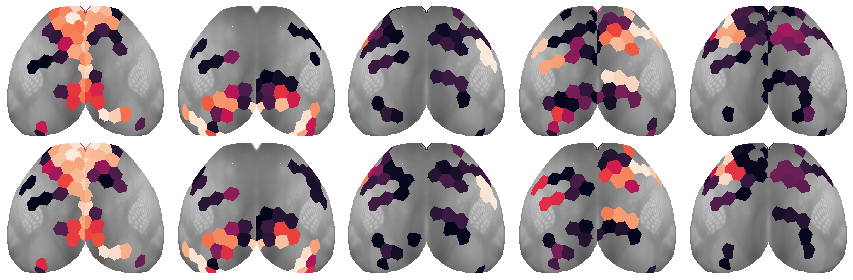

In [71]:
tr = gr.project_vec(pi)
tr = gr.trim2d(tr)
quick_show(tr2, tr)

In [72]:
data.shape

(2440, 154)

In [73]:
pi_all = self._cat_data(raw=False, which='pi')
pi_all.shape

(488, 5, 154)

In [74]:
mu = pi_all.mean(0)
sd = pi_all.std(0, ddof=1)

In [76]:
%%time
boot = bootstrap(
    x=pi_all,
    n_resamples=int(1e4),
    dims={'seed': len(pi_all)},
    est=bn.nanmean,
)
se = bn.nanstd(boot, axis=0, ddof=1)
boot.shape, se.shape

CPU times: user 15.8 s, sys: 26 ms, total: 15.8 s
Wall time: 15.8 s


((10000, 5, 154), (5, 154))

In [77]:
tval = sp_stats.t.ppf(0.995, 499)
lower = mu - tval * se

In [78]:
reject = lower < 0.003
reject.sum()

271

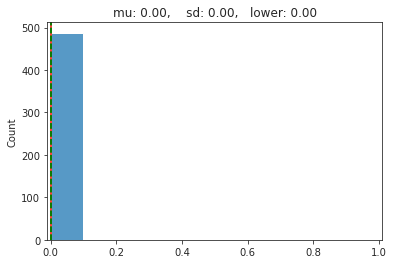

In [79]:
k = 4
n = 137
sns.histplot(pi_all[:, k, n], bins=np.linspace(0, 1, 11))
plt.title(f"mu: {mu[k, n]:0.2f},    sd: {sd[k, n]:0.2f},   lower: {lower[k, n]:0.2f}")
plt.axvline(mu[k, n], color='r', ls='-')
plt.axvline(mu[k, n] + sd[k, n], color='g', ls='--')
plt.axvline(mu[k, n] - sd[k, n], color='g', ls='--')
plt.xlim(-0.01, 1.01)
plt.show()

<AxesSubplot:ylabel='Count'>

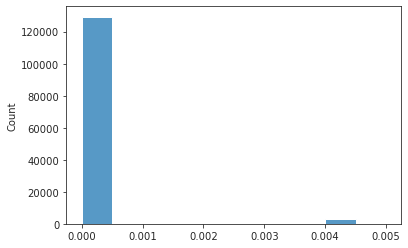

In [80]:
sns.histplot(pi_all[:, reject].ravel(), bins=np.linspace(0, 0.005, 11))

In [81]:
gam_all_0 = self._cat_data(raw=False, which='gam')
gam_all_0[:, reject] = 0.
gam = bn.nanmean(gam_all_0, 0)
pi = gam / np.nansum(gam, -2, keepdims=True)

In [82]:
gam_all = dc(gam_all_0)

In [83]:
nonzero = gam_all.sum(-2, keepdims=True) != 0
original_shape = gam_all.shape
ner = Normalizer()
gam_all = ner.fit_transform(
    gam_all.reshape(original_shape[0], -1))
gam_all = gam_all.reshape(original_shape)
gam_all *= self.num_k * original_shape[-1]
gam_all = np.where(nonzero, gam_all, np.nan)

In [84]:
np.unique(gam_all[:, 4, 137])

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [85]:
centroids = np.nanmean(gam_all, -3)
nonan = np.where(np.isnan(centroids).sum(0) == 0)[0]
perms = find_best_mappings(
    centroids=ner.fit_transform(centroids[:, nonan]),
    data={
        i: ner.fit_transform(gam_all[i][:, nonan])
        for i in range(original_shape[0])},
    match_metric='correlation',
    global_order=True,
    filter_nans=True,
)

In [86]:
gam_all_final = np.zeros_like(gam_all_0)

for i, v in perms.items():
    mapping_ids = list(v.values())
    if mapping_ids != list(range(self.num_k)):
        print(i, v, mapping_ids)
        gam_all_final[i, ...] = gam_all_0[i, mapping_ids, :]

2
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

5
{0: 0, 1: 1, 2: 4, 3: 3, 4: 2}
[0, 1, 4, 3, 2]

34
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

64
{0: 0, 1: 1, 2: 4, 3: 2, 4: 3}
[0, 1, 4, 2, 3]

88
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

107
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

111
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
[2, 1, 0, 3, 4]

128
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

135
{0: 2, 1: 1, 2: 0, 3: 3, 4: 4}
[2, 1, 0, 3, 4]

138
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

165
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

184
{0: 0, 1: 3, 2: 2, 3: 4, 4: 1}
[0, 3, 2, 4, 1]

188
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

204
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

224
{0: 2, 1: 1, 2: 3, 3: 0, 4: 4}
[2, 1, 3, 0, 4]

247
{0: 0, 1: 1, 2: 4, 3: 3, 4: 2}
[0, 1, 4, 3, 2]

306
{0: 0, 1: 2, 2: 1, 3: 3, 4: 4}
[0, 2, 1, 3, 4]

316
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

323
{0: 4, 1: 1, 2: 2, 3: 3, 4: 0}
[4, 1, 2, 3, 0]

327
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

399
{0: 3, 1: 1, 2: 2, 3: 0, 4: 4}
[3, 1, 2, 0, 4]

414
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

438
{0: 0, 1: 1, 2: 3, 3: 2, 4: 4}
[0, 1, 3, 2, 4]

453
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

483
{0: 4, 1: 1, 2: 0, 3: 3, 4: 2}
[4, 1, 0, 3, 2]

486
{0: 0, 1: 1, 2: 2, 3: 4, 4: 3}
[0, 1, 2, 4, 3]

In [87]:
gam_final = bn.nanmean(gam_all_final, 0)
pi_final = gam_final / np.nansum(gam_final, -2, keepdims=True)
pi_final.shape

(5, 154)

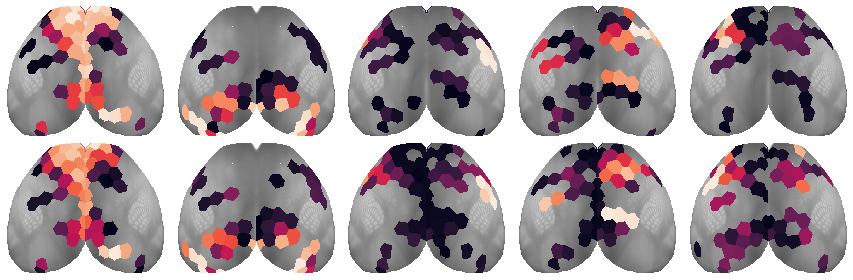

In [88]:
tr = gr.project_vec(pi)
tr = gr.trim2d(tr)

tr_final = gr.project_vec(pi_final)
tr_final = gr.trim2d(tr_final)
quick_show(tr, tr_final)

In [89]:
reject.sum()

271

## Check group

In [3]:
mice = Mice(128)

num_k, perc = 5, 10
props_base = {
    'perc': f'p{perc}-sample',
    'num_k': num_k,
    'mice': mice,
    'task': 'rest',
    'metric': 'pearson',
    'match_using': 'gam',
    'match_metric': 'euclidean',
    'graph_type': 'real',
    'verbose': False,
    'centroids_from': 'runs',
}
props_ca = {'mode': 'ca2', **props_base}
props_bo = {'mode': 'bold-lite', **props_base}

In [4]:
gr_bo = Group(**props_bo)
gr_ca = Group(**props_ca)

# svinets_bo = gr_bo.load_svinets()
# svinets_ca = gr_ca.load_svinets()

In [5]:
%%time

svinets_bo, perms_bo, centroids_bo = gr_bo.align_group()
svinets_ca, perms_ca, centroids_ca = gr_ca.align_group()

CPU times: user 5min 6s, sys: 7.37 s, total: 5min 13s
Wall time: 1min 11s


In [6]:
tr_bo = centroids_bo / np.nansum(centroids_bo, -2, keepdims=True)
tr_bo = gr_bo.project_vec(tr_bo)
tr_bo = gr_bo.trim2d(tr_bo)

tr_ca = centroids_ca / np.nansum(centroids_ca, -2, keepdims=True)
tr_ca = gr_ca.project_vec(tr_ca)
tr_ca = gr_ca.trim2d(tr_ca)

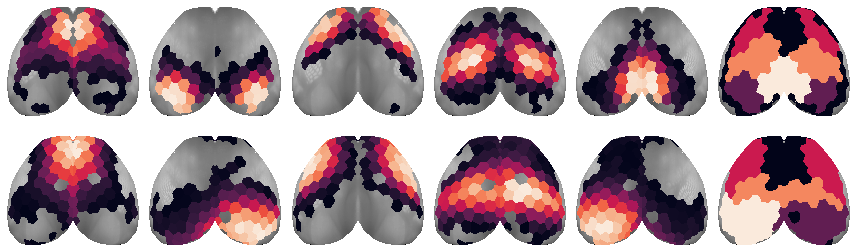

In [7]:
quick_show(tr_ca, tr_bo, 0.05)

In [8]:
data_ca = gr_ca.apply_perms(svinets_ca, perms_ca)

In [9]:
results_agg_ca = gr_ca.get_aggregate_data(data_ca, svinets_ca)

In [51]:
ctd_ca = results_agg_ca['centroids'].copy()
ctd_ca_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_ca, 2), 1), 0)
ctd_ca.shape, ctd_ca_avg.shape

((10, 3, 4, 5, 154), (5, 154))

In [52]:
ner = Normalizer()

ctd_ca_reord = np_nans(ctd_ca.shape)

looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    x = ctd_ca[i, j, k]
    good_nodes = np.where(np.isnan(x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    pperm = find_best_mappings(
        data={'data': x[:, good_nodes]},
        centroids=ner.fit_transform(ctd_ca_avg[:, good_nodes]),
        match_metric='correlation',
        global_order=True,
    )['data']
    ctd_ca_reord[i, j, k] = x[list(pperm.values())]
    
ctd_ca_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_ca_reord, 2), 1), 0)
ctd_ca_reord_avg.shape

(5, 154)

In [53]:
pi_ca = ctd_ca_avg / np.nansum(ctd_ca_avg, -2, keepdims=True)
tr_ca = gr_ca.project_vec(pi_ca)
tr_ca = gr_ca.trim2d(tr_ca)

In [54]:
pi_ca_reord = ctd_ca_reord_avg / np.nansum(ctd_ca_reord_avg, -2, keepdims=True)
tr_ca_reord = gr_ca.project_vec(pi_ca_reord)
tr_ca_reord = gr_ca.trim2d(tr_ca_reord)

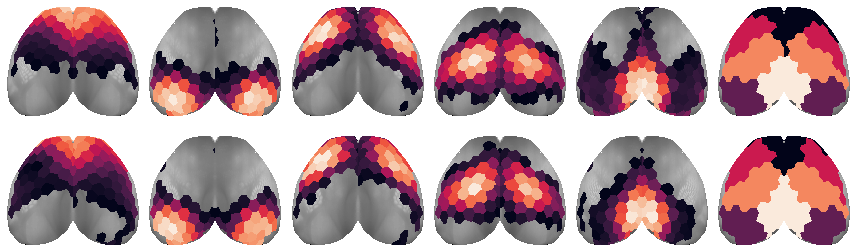

In [55]:
quick_show(tr_ca, tr_ca_reord)

In [56]:
data_bo = gr_bo.apply_perms(svinets_bo, perms_bo)

In [57]:
results_agg_bo = gr_bo.get_aggregate_data(data_bo, svinets_bo)

In [58]:
ctd_bo = results_agg_bo['centroids'].copy()
ctd_bo_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_bo, 2), 1), 0)
ctd_bo.shape, ctd_bo_avg.shape

((10, 3, 4, 5, 154), (5, 154))

In [59]:
ner = Normalizer()

ctd_bo_reord = np_nans(ctd_bo.shape)

looper = itertools.product(range(10), range(3), range(4))
for i, j, k in looper:
    x = ctd_bo[i, j, k]
    good_nodes = np.where(np.isnan(x).sum(0) == 0)[0]
    if not len(good_nodes):
        continue
    pperm = find_best_mappings(
        data={'data': x[:, good_nodes]},
        centroids=ner.fit_transform(ctd_bo_avg[:, good_nodes]),
        match_metric='correlation',
        global_order=True,
    )['data']
    ctd_bo_reord[i, j, k] = x[list(pperm.values())]
    
ctd_bo_reord_avg = bn.nanmean(bn.nanmean(bn.nanmean(ctd_bo_reord, 2), 1), 0)
ctd_bo_reord_avg.shape

(5, 154)

In [60]:
pi_bo = ctd_bo_avg / np.nansum(ctd_bo_avg, -2, keepdims=True)
tr_bo = gr_bo.project_vec(pi_bo)
tr_bo = gr_bo.trim2d(tr_bo)

In [61]:
pi_bo_reord = ctd_bo_reord_avg / np.nansum(ctd_bo_reord_avg, -2, keepdims=True)
tr_bo_reord = gr_bo.project_vec(pi_bo_reord)
tr_bo_reord = gr_bo.trim2d(tr_bo_reord)

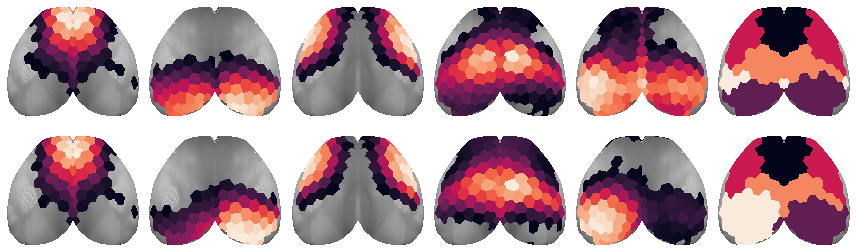

In [62]:
quick_show(tr_bo, tr_bo_reord)

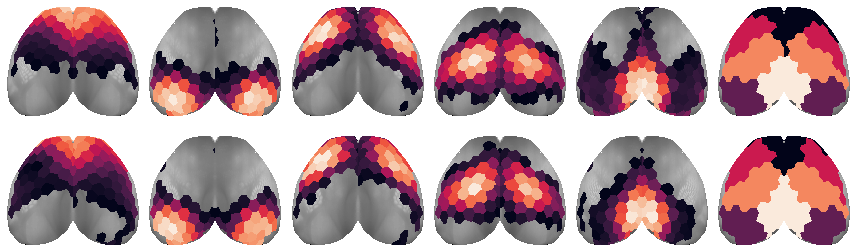

In [71]:
h_bo = sp_stats.entropy(pi_bo, axis=0) / np.log(5)
h_reord_bo = sp_stats.entropy(pi_bo_reord, axis=0) / np.log(5)

h_ca = sp_stats.entropy(pi_ca, axis=0) / np.log(5)
h_reord_ca = sp_stats.entropy(pi_ca_reord, axis=0) / np.log(5)

h = np.concatenate([np.expand_dims(h_ca, 0), np.expand_dims(h_bo, 0)])
h_reord = np.concatenate([np.expand_dims(h_reord_ca, 0), np.expand_dims(h_reord_bo, 0)])

tr_h = gr_ca.project_vec(h)
tr_h = gr_ca.trim2d(tr_h)

tr_h_reord = gr_ca.project_vec(h_reord)
tr_h_reord = gr_ca.trim2d(tr_h_reord)

In [87]:
sp_stats.pearsonr(h_bo, h_ca), sp_stats.pearsonr(h_reord_bo, h_reord_ca)

(
    (0.3114014471198811, 8.455631457561371e-05),
    (0.08366115197308562, 0.3022789348053852)
)

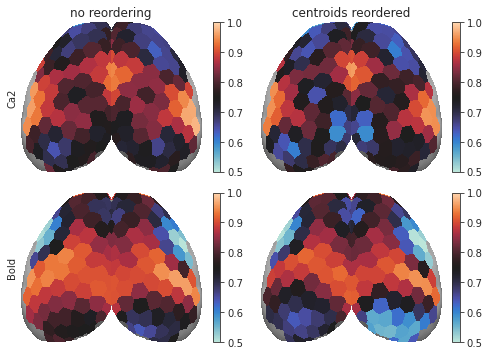

In [84]:
kwargs = {'cmap': 'icefire', 'vmin': 0.5, 'vmax': 1}

fig, axes = create_figure(2, 2, (7, 5))
for i in range(2):
    ax = axes[i, 0]
    ax.imshow(mwh(tr_h['top'] == 0, tr_h['top']), cmap='Greys_r')
    im = ax.imshow(mwh(tr_h['proj-top'][i] == 0, tr_h['proj-top'][i]), **kwargs)
    plt.colorbar(im, ax=ax)
    if i == 0:
        ax.set_title('no reordering')
    
    ax = axes[i, 1]
    ax.imshow(mwh(tr_h_reord['top'] == 0, tr_h_reord['top']), cmap='Greys_r')
    im = ax.imshow(mwh(tr_h_reord['proj-top'][i] == 0, tr_h_reord['proj-top'][i]), **kwargs)
    plt.colorbar(im, ax=ax)
    if i == 0:
        ax.set_title('centroids reordered')
    
axes[0, 0].set_ylabel('Ca2')
axes[1, 0].set_ylabel('Bold')

remove_ticks(axes)

<matplotlib.colorbar.Colorbar object at 0x7fb580d5fd00>

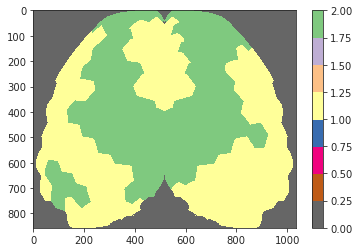

In [101]:
plt.imshow(tr_h_reord['proj-top'][2], cmap='Accent_r')
plt.colorbar()

<matplotlib.colorbar.Colorbar object at 0x7fb5a2429a30>

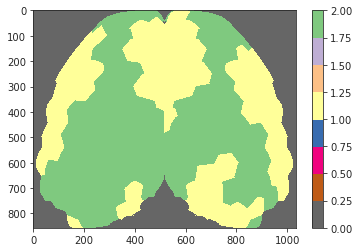

In [102]:
plt.imshow(tr_h['proj-top'][2], cmap='Accent_r')
plt.colorbar()

In [103]:
diff = np.concatenate([
    np.abs(h_bo - h_ca).reshape(1, -1),
    np.abs(h_reord_bo - h_reord_ca).reshape(1, -1)
])
diff = gr_ca.project_vec(diff)
diff = gr_ca.trim2d(diff)

<matplotlib.image.AxesImage object at 0x7fb5a38b7dc0>

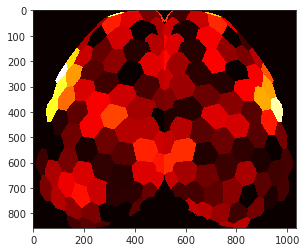

In [105]:
plt.imshow(diff['proj-top'][0], cmap='hot')

<matplotlib.image.AxesImage object at 0x7fb5a38cf2b0>

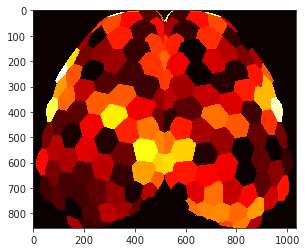

In [106]:
plt.imshow(diff['proj-top'][1], cmap='hot')

In [7]:
svinets = gr_ca.load_svinets()

In [8]:
node_in_runs = collections.defaultdict(list)
ctr = 0
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    ctr += 1
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    for n in good_nodes:
        node_in_runs[n].append(key)
node_in_runs = dict(sorted(node_in_runs.items()))
node_freq_good = {n: len(key_list) / ctr * 100 for n, key_list in node_in_runs.items()}

In [39]:
freq_thres = 90
good_global_nodes = [n for n, f in node_freq_good.items() if f > freq_thres]
len(good_global_nodes)

98

In [19]:
good_global_nodes

[
    0,
    1,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    16,
    17,
    18,
    19,
    20,
    21,
    22,
    23,
    24,
    25,
    26,
    27,
    28,
    29,
    30,
    31,
    32,
    33,
    34,
    35,
    36,
    37,
    38,
    40,
    41,
    42,
    43,
    44,
    45,
    46,
    47,
    48,
    49,
    50,
    51,
    52,
    53,
    54,
    55,
    56,
    57,
    58,
    59,
    60,
    61,
    62,
    63,
    64,
    65,
    66,
    67,
    68,
    69,
    70,
    71,
    72,
    73,
    74,
    75,
    76,
    77,
    78,
    80,
    81,
    82,
    83,
    84,
    85,
    86,
    87,
    88,
    89,
    90,
    91,
    92,
    93,
    94,
    95,
    96,
    97,
    98,
    99,
    100,
    101,
    102,
    103,
    104,
    105,
    106,
    107,
    108,
    109,
    111,
    112,
    113,
    114,
    115,
    116,
    117,
    118,
    119,
    120,
    121,
    122,
    123,
    124,
    125,
    126,
    127,
    128,
    129,
    130,
    131,
    132,
    133,
    134,
    135,
    136,
    137,
    138,
    140,
    141,
    142,
    143,
    144,
    145,
    146,
    147,
    149,
    150,
    151,
    152,
    153
]

In [40]:
accepted_runs = []
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    accept = all(e in good_nodes for e in good_global_nodes)
    if accept:
        accepted_runs.append(key)
len(accepted_runs), ctr

(54, 111)

In [41]:
svinets = gr_ca.load_svinets()
unord = {
    key: sv.gam_all.reshape(-1, len(self.n2l))
    for key, sv in svinets.items()
    if key in accepted_runs
}
which_keys = self._get_keys_to_use()
data = [
    v for k, v in unord.items()
    if k in which_keys
]
data = np.concatenate(data)
nonan = np.where(np.isnan(data).sum(0) == 0)[0]

data.shape, len(nonan)

((134820, 154), 99)

In [42]:
centroids = np_nans((5, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=5,
    match_metric='euclidean',
    random_state=self.mice.cfg.random_state,
)
centroids[:, nonan] = _centroids

In [43]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric=self.dist_metric,
    global_order=self.global_order,
)

In [44]:
centroids_before = dc(centroids)

In [45]:
centroids = centroids[global_mapping]
ner = Normalizer()
data_clean = {}

In [46]:
tr1 = centroids_before / np.nansum(centroids_before, -2, keepdims=True)
tr1 = gr_ca.project_vec(tr1)
tr1 = gr_ca.trim2d(tr1)

tr2 = centroids / np.nansum(centroids, -2, keepdims=True)
tr2 = gr_ca.project_vec(tr2)
tr2 = gr_ca.trim2d(tr2)

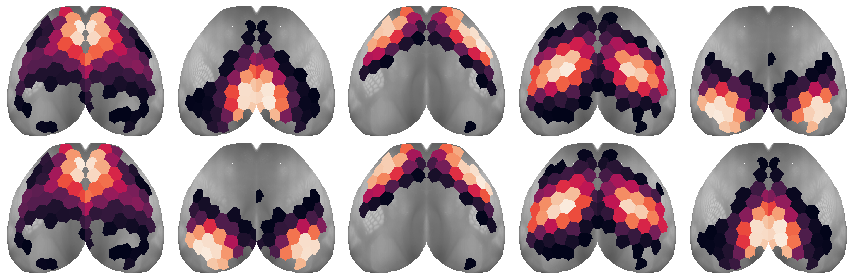

In [47]:
quick_show(tr1, tr2, 0.05)

In [6]:
self = gr_bo

In [7]:
svinets = self.load_svinets()

In [8]:
node_in_runs = collections.defaultdict(list)
ctr = 0
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    ctr += 1
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    for n in good_nodes:
        node_in_runs[n].append(key)
node_in_runs = dict(sorted(node_in_runs.items()))
node_freq_good = {n: len(key_list) / ctr * 100 for n, key_list in node_in_runs.items()}

In [9]:
freq_thres = 90
good_global_nodes = [n for n, f in node_freq_good.items() if f > freq_thres]
len(good_global_nodes)

148

In [10]:
accepted_runs = []
for key, sv in svinets.items():
    if 'run' not in key:
        continue
    good_nodes = np.where(np.isnan(sv.gam).sum(0) == 0)[0]
    accept = all(e in good_nodes for e in good_global_nodes)
    if accept:
        accepted_runs.append(key)
len(accepted_runs), ctr

(43, 115)

In [11]:
unord = {
    key: sv.gam_all.reshape(-1, len(self.n2l))
    for key, sv in svinets.items()
    if key in accepted_runs
}
which_keys = self._get_keys_to_use()
data = [
    v for k, v in unord.items()
    if k in which_keys
]
data = np.concatenate(data)
nonan = np.where(np.isnan(data).sum(0) == 0)[0]

data.shape, len(nonan)

((107475, 154), 148)

In [12]:
centroids = np_nans((5, data.shape[-1]))
_centroids, _ = fit_kmeans(
    data=data[:, nonan],
    n_clusters=5,
    match_metric='euclidean',
    random_state=self.mice.cfg.random_state,
)
centroids[:, nonan] = _centroids

In [13]:
global_mapping = self.align_centroid_to_structs(
    pi_mv=centroids,
    dist_metric=self.dist_metric,
    global_order=self.global_order,
)

In [14]:
centroids_before = dc(centroids)

In [15]:
centroids = centroids[global_mapping]
ner = Normalizer()
data_clean = {}

In [16]:
tr1 = centroids_before / np.nansum(centroids_before, -2, keepdims=True)
tr1 = gr_ca.project_vec(tr1)
tr1 = gr_ca.trim2d(tr1)

tr2 = centroids / np.nansum(centroids, -2, keepdims=True)
tr2 = gr_ca.project_vec(tr2)
tr2 = gr_ca.trim2d(tr2)

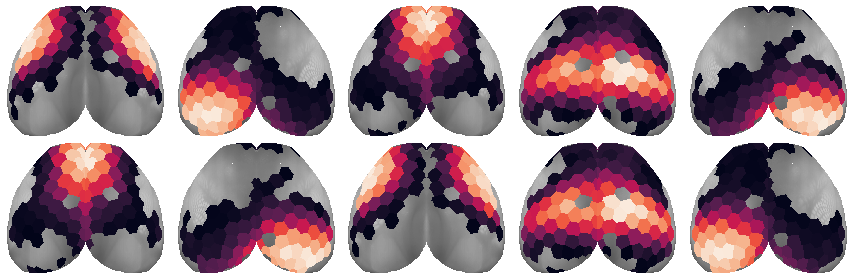

In [17]:
quick_show(tr1, tr2, 0.05)

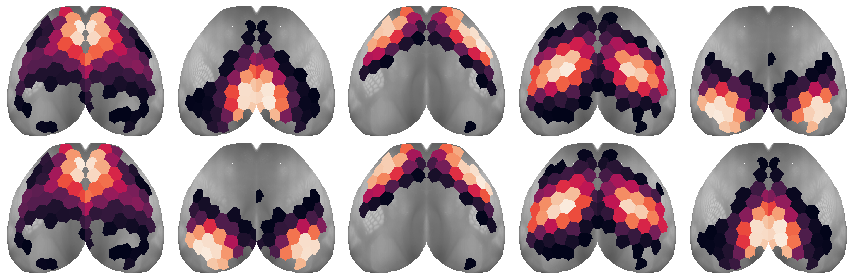

In [27]:
for k, x in unord.items():
    _x = x[:, nonan]
    _x = np.where(~np.isnan(_x), _x, 0.0)
    data_clean[k] = ner.fit_transform(_x)
perms = find_best_mappings(
    centroids=ner.fit_transform(centroids[:, nonan]),
    data=data_clean,
    match_metric='correlation',
    global_order=True,
)

In [28]:
self.perms = perms

In [29]:
permuted = self.apply_perms(svinets, perms)

In [38]:
permuted['sub-SLC05_ses-1_run-7']['gam'].shape

(494, 5, 154)